In [ ]:
!pip install -qU langgraph langchain langsmith langchain_openai openai datasets langchainhub langchain_community

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'YOUR_OPENAI_API_KEY'

# Competitive Programming

The original paper "Can Language Models Solve Olympiad Programming?" proposed a computing olympiad agent that leverages three complementary techniques to boost performance: **reflection**, **retrieval**, and **human-in-the-loop** collaboration.

In this section, we will construct an agentic graph capable of answering programming questions of increasing difficulty:
1. **Reflection**: we will create a zero-shot tool calling agent and prompt it to reflect on the test case results to correct its initial errors. This is similar to the agent the paper reported as having a pass rate of 12.38 on the USACO benchmark.
2. **Retrieval**: we will implement an initial retrieval step as "episodic memory" for the agent that retrieves high-quality few-shot examples from our corpora of programming problems to help solve the bronze level question. This agent is similar to the one the paper benchmarked at 20.2.
3. **Human-in-the-loop**: we will use `interrupt_after` to let the user copilot the agent to a better answer. This benchmark performance then is constrained only by the competitiveness of the human it is paired with.

# Setup

## Data

Fetch the USACO benchmark data

In [3]:
import os
import zipfile
import datasets
import requests

usaco_url = 'https://storage.googleapis.com/benchmarks-artifacts/usaco/usaco_sampled_with_tests.zip'
zip_path = 'usaco.zip'
extract_path = 'usaco_datasets'

response = requests.get(usaco_url)
with open(zip_path, 'wb') as file:
    file.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.remove(zip_path)

ds = datasets.load_from_disk(
    os.path.join(extract_path, 'usaco_v3_sampled_with_tests')
)

## Test Evaluation Utils

We also need a way to evaluate our generated code. Will use an unsafe code execution program to run the generated code against our test cases.

In [4]:
import multiprocessing
import queue
import subprocess
import sys
import time
import traceback

multiprocessing.set_start_method('fork', force=True)

# WARNING
# This program exists to execute untrusted model-generated code.
# Although it is highly unlikely that model-generated code will
# do something overly malicious in response to this test suite,
# model-generated code may act destructively due to a lack of
# model capability or alignment.
# Users are strongly encouraged to sandbox this evaluation suite
# so that it does not perform destructive actions on their host.

# Proceed at your own risk:

def exec_program(q, program, input_data, expected_output, timeout):
    try:
        start_time = time.time()
        process = subprocess.Popen(
            [sys.executable, '-c', program],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
        )
        stdout, stderr = process.communicate(input=input_data, timeout=timeout)

        if time.time() - start_time > timeout:
            raise TimeoutError("Execution timed out.")
        if process.returncode != 0:
            q.put(f"Failed: {stderr}")
        else:
            if stdout.strip() == expected_output.strip():
                q.put('Passed')
            else:
                q.put(f"Wrong answer. Expected: '{expected_output}', got '{stdout}'")

    except subprocess.TimeoutExpired:
        process.kill()
        q.put('Timed out')
    except Exception:
        q.put(f"Failed: {traceback.format_exc()}")



def check_correctness(
        program: str, input_data: str, expected_output: str, timeout: float,
) -> str:
    q = multiprocessing.Queue()
    process = multiprocessing.Process(
        target=exec_program,
        args=(q, program, input_data, expected_output, timeout),
    )

    process.start()
    process.join(timeout=timeout + 1)
    if process.is_alive():
        process.terminate()
        process.join()
        result = 'Timed out'
    else:
        try:
            result = q.get_nowait()
        except queue.Empty:
            result = 'No result returned'

    return result

In [5]:
# test an example program
program_code = "print('hello world!')"
input_data = ""
expected_output = "hello world!"
timeout = 2

test_result = check_correctness(program_code, input_data, expected_output, timeout)
print("Example 1: ", test_result)

test_result = check_correctness("print('goodbye')", input_data, "hi there", timeout)
print("Example 2: ", test_result)

Example 1:  Passed
Example 2:  Wrong answer. Expected: 'hi there', got 'goodbye
'


# Part 1: Zero-Shot with Reflection

In this section, we will build a simple zero-shot tool-calling agent to try to solve these problems. We will incorporate a simple form of reflection directly in the agent's tool calling schema by adding a "reasoning" field.

## State

LangGraph's main primitive is the `StateGraph`, which we use to define an agent as a controllable state machine.

The graph has `node`s (python functions) that perform the work, and `edge`s that define how to route between the nodes. The `State` defines the interface between each node and carries all the information our agent needs.

In the example below, we define a `State` for our programming olympaid agent. The `message` will track the sequence of submissions (and test case feedback) as chat history. The `status` field will flip from `in_progress` to `success` if the submission passes all test cases. The other fields (`test_cases`, `runtime_limit`) are used by the `evaluation` node to test the agent's submissions. These values are not seen by the agent itself.

In [6]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class TestCase(TypedDict):
    inputs: str
    outputs: str


class State(TypedDict):
    # Append-only chat memory so the agent can try to recover from initial mistakes.
    messages: Annotated[list[AnyMessage], add_messages]
    # From the dataset. These are used for testing.
    test_cases: list[TestCase]
    runtime_limit: int
    status: str

Convert the dataset into inputs that our graph will accept.

In [7]:
input_states = [
    {
        'messages': [('user', row['description'])],
        'test_cases': row['test_cases'],
        'runtime_limit': row['runtime_limit'],
        'status': 'in_progress',
        'problem_level': row['problem_level'],
    }
    for row in ds
]

### Node 1: Solver

Create a `solver` node that prompts an LLM "agent" to use a `writePython` tool to generate the submitted code.

In [12]:
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field


class writePython(BaseModel):
    """Write python code that resolves the problem."""

    reasoning: str = Field(
        ...,
        description="Conceptual solution."
    )
    pseudocode: str = Field(
        ...,
        description="Detailed English pseudocode."
    )
    code: str = Field(
        ...,
        description="Valid Python 3 solution to the problem."
    )


class Solver:
    def __init__(self, llm: BaseChatModel, prompt: ChatPromptTemplate):
        self.runnable = prompt | llm.bind_tools([writePython])

    def __call__(self, state: State) -> dict:
        # Our agent only can see the "messages" and will ignore the test info
        return {'messages': [self.runnable.invoke({'messages': state['messages']})]}

Now we can create the solver.

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI

# For this section, we are testing zero-shot performance and
# will not have any examples.
# Partial them out to pre-fill the template.
prompt = hub.pull('wfh/usaco-draft-solver').partial(examples="")
print("*"*35 + "Prompt" + "*"*35)
prompt.pretty_print()\

llm = ChatOpenAI(model='gpt-4o-mini')

solver = Solver(llm, prompt)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


***********************************Prompt***********************************
================================ System Message ================================

You are a world-class competitive programmer.
Please reply with a Python 3 solution to the problem below. 
First, reason through the problem and conceptualize a solution.
Then write detailed pseudocode to uncover any potential logical errors or omissions.
Finally output the working Python code for your solution, ensuring to fix any errors uncovered while writing pseudocode.

No outside libraries are allowed.{examples}

============================= Messages Placeholder =============================

{messages}


### Node 2: Evaluate

Now we define the `evaluate` node. This node takes the `solver`'s submitted code and executes it against the `test_cases` in our `State`. This uses the unsafe `check_correctness` utility we defined in the setup above.

In [10]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# This is the node we will add to the graph.
# Most tool-calling APIs require that the `ToolMessage` contains the ID of the tool calls
def format_tool_message(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response + "\nMake all fixes using the writePython tool.",
        tool_call_id=ai_message.tool_calls[0]['id'],
    )


def evaluate(state: State):
    test_cases = state['test_cases']
    ai_message: AIMessage = state['messages'][-1]

    if not ai_message.tool_calls:
        return {
            'messages': [
                HumanMessage(
                    content="No code submitted. Please try again using the correct python code."
                )
            ]
        }

    try:
        code = ai_message.tool_calls[0]['args']['code']
    except Exception as e:
        return {'messages': [format_tool_message(repr(e), ai_message)]}

    num_test_cases = len(test_cases)
    succeded = 0
    test_results = []

    for test_case in test_cases:
        input_data = test_case['inputs']
        expected_output = test_case['outputs']
        test_result = check_correctness(code, input_data, expected_output, timeout)
        test_results.append(test_result)
        if test_result == 'Passed':
            succedded += 1

    pass_rate = succeded / num_test_cases if num_test_cases else "N/A"
    if pass_rate == 1:
        return {'status': 'success'}

    responses = "\n".join(
        [f"<test id={i}>\n{r}\n</test>" for i, r in enumerate(test_results)]

    )

    response = f"Incorrect submission. Please respond with updated code.\nPass rate: {succeded}/{num_test_cases}\nResults:\n{responses}"
    formatted_message = format_tool_message(response, ai_message)
    return {'messages': [formatted_message]}

### Create Graph

Our zero-shot graph defines a loop. If we visualize the data flow, we want the logic to
1. Go to the `solver`, which attempts a first solution.
2. Go to the `evaluate` node, which tests the solution.
3. If the solution passes, end, otherwise, return to the `solver` to try again.

In [ ]:
from langgraph.graph import START, END, StateGraph

builder = StateGraph(State)
builder.add_node('solver', solver)
builder.add_node('evaluate', evaluate)

builder.add_edge(START, 'solver')
builder.add_edge('solver', 'evaluate')

def control_edge(state: State):
    if state.get('status') == 'success':
        return END
    return 'solver'

builder.add_conditional_edges(
    'evaluate',
    control_edge,
    {END: END, 'solver': 'solver'}
)

graph = builder.compile()

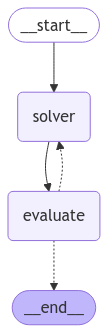

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Now we can see the type of question it will have to solve.

In [23]:
input_state = input_states[0].copy()

# We will reduce the test cases to speed up
input_state['test_cases'] = input_state['test_cases'][:3]
print(input_state['messages'][0][1])


Farmer John has $N$ ($1 \leq N \leq 2 \cdot 10^5$) farms, numbered from $1$ to
$N$. It is known that FJ closes farm $i$ at time $c_i$. Bessie wakes up at time
$S$, and wants to maximize the productivity of her day by visiting as many farms
as possible before they close. She plans to visit farm $i$ on time $t_i + S$.
Bessie must arrive at a farm strictly before Farmer John closes it to actually visit it.

Bessie has $Q$ $(1 \leq Q \leq 2 \cdot 10^5)$ queries. For each query, she gives
you two integers $S$ and $V$. For each query, output whether Bessie can visit at
least $V$ farms if she wakes up at time $S$.

INPUT FORMAT (input arrives from the terminal / stdin):
The first line consists of $N$ and $Q$.

The second line consists of $c_1, c_2, c_3 \dots c_N$ ($1 \leq c_i \leq 10^6$).

The third line consists of $t_1, t_2, t_3 \dots t_N$ ($1 \leq t_i \leq 10^6$).

The next $Q$ lines each consist of two integers $V$ ($1 \leq V \leq N$) and $S$
($1 \leq S \leq 10^6$).

OUTPUT FORMAT (print

We expect a `GraphRecursionError` here from it not being able to answer it correctly in the allocated number of steps due to the difficulty of this question.

In [ ]:
from langchain_core.tracers.context import tracing_v2_enabled
from langsmith import Client

# We do not need to include all the test cases in our traces.
def _hide_test_cases(inputs):
    copied = inputs.copy()
    # These are tens of MB in size. No need to send them up
    copied['test_cases'] = "..."
    return copied


client = Client(hide_inputs=_hide_test_cases, hide_outputs=_hide_test_cases)
with tracing_v2_enabled(client=client):
    events = graph.stream(input_state)
    for event in events:
        for value in event.values():
            messages = value.get('messages')
            if messages:
                if isinstance(messages, list):
                    messages = value['messages'][-1]

                print('Assistant:', str(messages.content).replace('\n', '\\n')[:50])

# Part 2: Few-shot Retrieval

Even with reflective tool calling, our baseline agent from Part 1 struggled with this task. One way to teach an LLM how to better perform a task is through demonstrations, also known as "few-shot examples".

What the authors of the USACO paper call "episodic memory" is the **few-shot prompting over similar examples**.

Each example in this case is a different problem + solution within the dataset. The term "episodic memory" makes sense if we pretend our agent has already "solved" these problems and is recalling its solutions to them.


This memory step is performed **one time, before** the logic of our zero-shot loop from Part 1. The steps are as follows:
1. Prompt the LLM to generate a candidate solution.
2. Use the text of the candidate solution to retrieve the N most similar (problem, solution) pairs.
3. Format this result in the Zero-shot agent's prompt.

In this section, we will implement our episodic memory as a retriever. We will follow the paper's retriever selection and use BM25.

In [8]:
!pip install -qU rank_bm25

## State

The state is mostly recycled from Part 1. Add additional "candiadte" and "examples" fields to store the information for the memory steps.

In [25]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages



class TestCase(TypedDict):
    inputs: str
    outputs: str


class State(TypedDict):
    # NEW!
    # Candidate for retrieval + formatted fetched examples as memory
    candidate: AIMessage
    examples: str
    # Repeated from Part 1
    messages: Annotated[list[AnyMessage], add_messages]
    test_cases: list[TestCase]
    runtime_limit: int
    status: str

## Nodes 1 and 3: Draft and Solver

In [26]:
from langchain import hub
from langchain_openai import ChatOpenAI


class Solver:
    def __init__(self, llm: BaseChatModel, prompt: ChatPromptTemplate):
        self.runnable = prompt | llm.bind_tools([writePython])

    def __call__(self, state: State) -> dict:
        # Our agent only can see the "messages" and will ignore the test info
        inputs = {'messages': state['messages']}
        has_examples = bool(state.get('examples'))
        output_key = 'candidate' # used in the draft node

        if has_examples:
            output_key = 'messages'
            # used in the solve node
            inputs['examples'] = state['examples']

        response = self.runnable.invoke(inputs)
        if not response.content:
            return {
                output_key: AIMessage(
                    content="I'll need to think about this step by step."
                )
            }

        return {output_key: response}

In [27]:
prompt = hub.pull('wfh/usaco-draft-solver')
llm = ChatOpenAI(model='gpt-4o-mini')

draft_solver = Solver(llm, prompt.partial(examples=""))
solver = Solver(llm, prompt)

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


## Node 2: Retrieve

The retrieve node takes a candidate solution (made by the `solver` node), use this to search for similar examples, then formats those in the message.

In [28]:
# We will test our agent on index 0 (the same as above).
# Later, we will test on index 2 (the first 'silver difficulty' question)
test_indices = [0, 2]

train_ds = [
    row for i, row in enumerate(ds) if i not in test_indices
]
test_ds = [
    row for i, row in enumerate(ds) if i in test_indices
]

In [29]:
from langchain_community.retrievers import BM25Retriever

def format_example(row):
    question = row['description']
    answer = row['solution']

    return f"""<problem>
    {question}
    </problem>
    <solution>
    {answer}
    </solution>"""


# Skip our `test_examples` to avoid cheating
# This is "simulating" having seen other in-context examples
retriever = BM25Retriever.from_texts(
    [format_example(row) for row in train_ds]
)

Now define the node.

Any node can optionally accept a second `config` positional argument. This contains `configurable` params we can adjust when invoking the graph. For instance, we can adjust the top `k` examples to retrieve for our agent.

In [30]:
from langchain_core.runnables import RunnableConfig


def retrieve_examples(state: State, config: RunnableConfig):
    top_k = config['configurable'].get('k') or 2
    ai_message: AIMessage = state['candidate']
    if not ai_message.tool_calls:
        # Error! To make more robust, we could loop back
        raise ValueError("Draft agent did not produce a valid code block")

    code = ai_message.tool_calls[0]['args']['code']
    examples_str = "\n".join(
        [doc.page_content for doc in retriever.invoke(code)[:top_k]]
    )

    examples_str = f"""
    You previously solved the following problems in this competition:
    <Examples>
    {examples_str}
    </Examples>
    Approach this new question with similar sophistication."""

    return {'examples': examples_str}

## Graph

The graph is slightly more complicated than in Part 1, since we have to add the initial "draft" and "retrieve" nodes to our agent loop.

In [31]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph

builder = StateGraph(State)
# Add nodes
builder.add_node('draft', draft_solver)
builder.add_node('retrieve', retrieve_examples)
builder.add_node('solve', solver)
builder.add_node('evaluate', evaluate)
# Add edges
builder.add_edge(START, 'draft')
builder.add_edge('draft', 'retrieve')
builder.add_edge('retrieve', 'solve')
builder.add_edge('solve', 'evaluate')

def control_edge(state: State):
    if state.get('status') == 'success':
        return END
    return 'solve'

builder.add_conditional_edges(
    'evaluate',
    control_edge,
    {END: END, 'solve': 'solve'},
)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

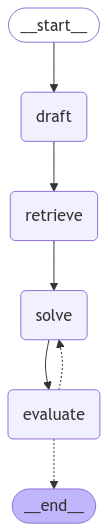

In [32]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {'configurable': {'thread_id': 'question-recall', 'k': 3}}

with tracing_v2_enabled(client=client):
    events = graph.stream(input_state, config)
    for event in events:
        for value in event.values():
            messages = value.get('messages')
            if messages:
                if isinstance(messages, list):
                    messages = value['messages'][-1]

                print(
                    'Assistant:',
                    str(messages.content).replace('\n', '\\n')[:50],
                )
            elif value.get('examples'):
                print(
                    "Retrieved examples:\n\n", value['examples'][:100] + '...'
                )
            elif value.get('candidate'):
                print(str(value['candidate'].content)[:200])

In [ ]:
checkpoint = graph.get_state(config)
checkpoint.values["status"]

In [ ]:
silver_row = test_ds[1]
silver_row["problem_level"]

In [ ]:
silver_input = {
    "messages": [("user", silver_row["description"])],
    "test_cases": silver_row["test_cases"],
    "runtime_limit": silver_row["runtime_limit"],
    "status": "in_progress",
}


config = {"configurable": {"thread_id": "silver-question-1", "k": 2}}
with tracing_v2_enabled(client=client):
    events = graph.stream(silver_input, config)
    for event in events:
        for value in event.values():
            messages = value.get("messages")
            if messages:
                if isinstance(messages, list):
                    messages = value["messages"][-1]
                print(
                    "Assistant:",
                    str(messages.content).replace("\n", "\\n")[:50],
                )
            elif value.get("examples"):
                print("Retrieved examples:\n\n", value["examples"][:100] + "...")
            elif value.get("candidate"):
                print(str(value["candidate"].content)[:200])

# Part 3: Human-in-the-loop

Our retrieval-enhanced agent was able to solve the `bronze`-level question but still failed for those with the more challenging `silver` difficulty.

The paper presented 3 complementary techniques that improved performance:
1. Reflection: explicitly prompting the LLM to "reflect" on its mistakes can help it
2. Few-shot prompting: retrieving relevant, high-quality examples as "memory"
3. **Human-in-the-loop collaboration**: without giving the correct answer, the human is allowed to help the agent reflect on its approach and point it in a better direction.

In LangGraph, we need to instruct the graph to `interrupt_after` the "`evaluate`" node to give the user a chance to modify the trajectory.

In [34]:
# This is all the same as before
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph


builder = StateGraph(State)
prompt = hub.pull('wfh/usaco-draft-solver')
llm = ChatOpenAI(model='gpt-4o-mini')

draft_solver = Solver(llm, prompt.partial(example=""))
solver = Solver(llm, prompt)

builder.add_node('draft', draft_solver)
builder.add_node('retrieve', retrieve_examples)
builder.add_node('solve', solver)
builder.add_node('evaluate', evaluate)

builder.add_edge(START, 'draft')
builder.add_edge('draft', 'retrieve')
builder.add_edge('retrieve', 'solve')
builder.add_edge('solve', 'evaluate')

def control_edge(state: State):
    if state.get('status') == 'success':
        return END
    return 'solve'

builder.add_conditional_edges(
    'evaluate',
    control_edge,
    {END: END, 'solve': 'solve'},
)

checkpointer = MemorySaver()

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Now we finish by compiling the graph, and set `interrupt_after=['evaluate']` to instruct the agent to wait for human input before continuing execution.

In [35]:
graph = builder.compile(
    checkpointer=checkpointer,
    # NEW!
    # This tells the graph to break any time it goes to the "human" node
    interrupt_after=['evaluate'],
)

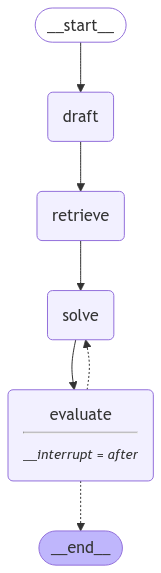

In [36]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

As we can see in the graph above, the structure is the same as Part 2, except that we have inserted a "`human`" breakpoint between the "`evaluate`" and "`solve`" nodes.

In [ ]:
config = {"configurable": {"thread_id": "silver-hl-1", "k": 2}}
with tracing_v2_enabled(client=client):
    events = graph.stream(silver_input, config)
    for event in events:
        for value in event.values():
            messages = value.get("messages")
            if messages:
                if isinstance(messages, list):
                    messages = value["messages"][-1]
                print(
                    "Assistant:",
                    str(messages.content).replace("\n", "\\n")[:50],
                )
            elif value.get("examples"):
                print("Retrieved examples:\n\n", value["examples"][:100] + "...")
            elif value.get("candidate"):
                print(str(value["candidate"].content)[:200])

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][0].content)

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-2].content[0]["text"])
print("\n\nCode:\n\n")
print(snapshot.values["messages"][-2].tool_calls[0]["args"]["code"])

In [ ]:
print(snapshot.values["messages"][-1].content[:200])